In [1]:
import pandas as pd
from pathlib import Path

In [38]:
file = pd.read_csv(Path("Resources/diabetes_indicators.csv"), encoding="UTF-8")
dm_df = pd.DataFrame(file)
dm_df.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


In [47]:
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# NN_MODEL_1

In [24]:
# Remove Diabetes_012 target from features data on original data set
y = dm_df.Diabetes_012.values.reshape(-1, 1)
X = dm_df.drop(columns="Diabetes_012").values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [25]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=21))
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
5946/5946 [==============================] - 3s 545us/step - loss: 0.3468 - accuracy: 0.7129
Epoch 2/50
5946/5946 [==============================] - 3s 546us/step - loss: 0.1440 - accuracy: 0.7321
Epoch 3/50
5946/5946 [==============================] - 3s 525us/step - loss: -0.6639 - accuracy: 0.7286
Epoch 4/50
5946/5946 [==============================] - 3s 535us/step - loss: -2.6882 - accuracy: 0.7274
Epoch 5/50
5946/5946 [==============================] - 3s 528us/step - loss: -6.4976 - accuracy: 0.7222
Epoch 6/50
5946/5946 [==============================] - 3s 526us/step - loss: -12.4879 - accuracy: 0.7222
Epoch 7/50
5946/5946 [==============================] - 3s 514us/step - loss: -21.5262 - accuracy: 0.7254
Epoch 8/50
5946/5946 [==============================] - 3s 506us/step - loss: -33.7259 - accuracy: 0.7221
Epoch 9/50
5946/5946 [==============================] - 3s 532us/step - loss: -50.1032 - accuracy: 0.7190
Epoch 10/50
5946/5946 [==============================

# NN_MODEL_2 with reduced features

In [27]:
# Remove Diabetes_012 target from features data on original data set
y = dm_df.Diabetes_012.values.reshape(-1, 1)
X = dm_df.drop(columns=["Diabetes_012","NoDocbcCost"]).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [28]:
 #Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=20))
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
5946/5946 [==============================] - 3s 521us/step - loss: 0.3581 - accuracy: 0.7054
Epoch 2/50
5946/5946 [==============================] - 3s 503us/step - loss: 0.2843 - accuracy: 0.7253
Epoch 3/50
5946/5946 [==============================] - 3s 482us/step - loss: 0.0138 - accuracy: 0.7259
Epoch 4/50
5946/5946 [==============================] - 3s 505us/step - loss: -0.8811 - accuracy: 0.7228
Epoch 5/50
5946/5946 [==============================] - 3s 486us/step - loss: -2.8354 - accuracy: 0.7195
Epoch 6/50
5946/5946 [==============================] - 3s 496us/step - loss: -6.2008 - accuracy: 0.7196
Epoch 7/50
5946/5946 [==============================] - 3s 508us/step - loss: -11.3211 - accuracy: 0.7177
Epoch 8/50
5946/5946 [==============================] - 3s 468us/step - loss: -18.6767 - accuracy: 0.7172
Epoch 9/50
5946/5946 [==============================] - 3s 518us/step - loss: -28.5918 - accuracy: 0.7158
Epoch 10/50
5946/5946 [==============================] 

# Converting Diabetes from 0,1,2 converting 2s to 1. [0 = No Diabetes / 1= Diabetes]

In [37]:
di_df = dm_df.copy()

di_df['Diabetes_012'] = di_df['Diabetes_012'].replace(2, 1)

di_df.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


# Setting up Random Forest Model

In [40]:
# Define features and target vectors

X = di_df.copy()
X.drop("Diabetes_012", axis=1, inplace=True)

y= di_df["Diabetes_012"].values.reshape(-1,1)
y[:5]


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [41]:
#Splitting into Train and Test sets
#Create Standardscaler
#Fitting Standard Scaler
#Scaling Data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [48]:
# Create a random forest classifier
# Fitting the model

rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)

/Users/adriansandoval/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [49]:
# Making predictions using the testing data

predictions = rf_model.predict(X_test_scaled)

In [51]:
# Calculating the confusion matrix
# Calculating the accuracy score
# Displaying results

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


acc_score = accuracy_score(y_test, predictions)


print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,51412,1936
Actual 1,7951,2121


Accuracy Score : 0.8441028066855881
Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     53348
         1.0       0.52      0.21      0.30     10072

    accuracy                           0.84     63420
   macro avg       0.69      0.59      0.61     63420
weighted avg       0.81      0.84      0.82     63420



In [59]:
# Random Forests in sklearn will automatically calculate feature importance
# We can sort the features by their importance

importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.18435015047119874, 'BMI'),
 (0.12215075371232553, 'Age'),
 (0.09797223327124552, 'Income'),
 (0.08243301078357763, 'PhysHlth'),
 (0.07179949814474676, 'GenHlth'),
 (0.06841805535093318, 'Education'),
 (0.06441154878330084, 'MentHlth'),
 (0.04337450747995499, 'HighBP'),
 (0.03355117781369951, 'Smoker'),
 (0.0329205960116296, 'Fruits'),
 (0.028451621863571922, 'Sex'),
 (0.027878259883816443, 'HighChol'),
 (0.025762535086327386, 'Veggies'),
 (0.025723797630693455, 'PhysActivity'),
 (0.024258824570129504, 'DiffWalk'),
 (0.018605025286501216, 'HeartDiseaseorAttack'),
 (0.015040902929785539, 'NoDocbcCost'),
 (0.01234675801023378, 'Stroke'),
 (0.008631680678238418, 'AnyHealthcare'),
 (0.00804023961916816, 'HvyAlcoholConsump'),
 (0.0038788226189216835, 'CholCheck')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

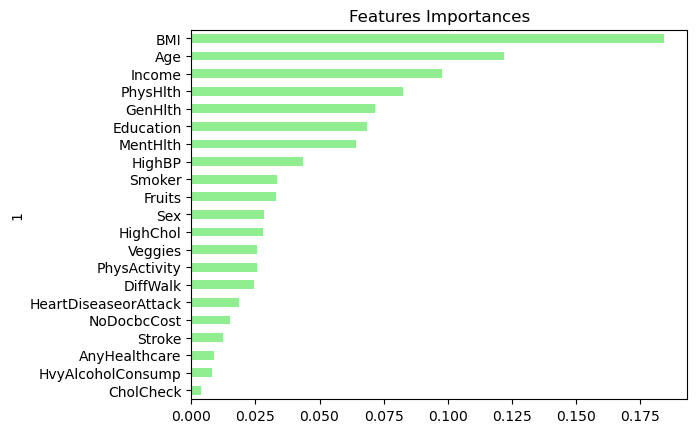

In [53]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest Model 2

In [80]:
#RandomForest Model 2 
X = di_df.copy()
X.drop(["Diabetes_012","CholCheck","HvyAlcoholConsump","Stroke","NoDocbcCost","AnyHealthcare","HeartDiseaseorAttack","DiffWalk","PhysActivity","Veggies","HighChol","Sex",], axis=1, inplace=True)

y= di_df["Diabetes_012"].values.reshape(-1,1)
y[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [81]:
#Splitting into Train and Test sets
#Create Standardscaler
#Fitting Standard Scaler
#Scaling Data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [82]:
# Create a random forest classifier
# Fitting the model

rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data

predictions = rf_model.predict(X_test_scaled)

/Users/adriansandoval/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [83]:
# Calculating the confusion matrix
# Calculating the accuracy score
# Displaying results

cm2 = confusion_matrix(y_test, predictions)
cm_df2 = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


acc_score = accuracy_score(y_test, predictions)


print("Confusion Matrix")
display(cm_df2)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,50588,2760
Actual 1,7856,2216


Accuracy Score : 0.8305739514348786
Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.90     53348
         1.0       0.43      0.22      0.29     10072

    accuracy                           0.83     63420
   macro avg       0.65      0.58      0.60     63420
weighted avg       0.80      0.83      0.81     63420



# #NN Model utilizing KerasTuner recommendations

In [ ]:

# Remove Diabetes_012 target from features data on original data set

y = dm_df.Diabetes_012.values
X = dm_df.drop(columns=["Diabetes_012","CholCheck","HvyAlcoholConsump","Stroke","NoDocbcCost","AnyHealthcare","DiffWalk","PhysActivity","Veggies","HighChol","Sex",]).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [78]:
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=26, activation="tanh", input_dim=10))
nn_model.add(tf.keras.layers.Dense(units=1, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=26, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=21, activation="tanh"))

nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
5946/5946 [==============================] - 4s 646us/step - loss: 0.3577 - accuracy: 0.8435
Epoch 2/50
5946/5946 [==============================] - 4s 636us/step - loss: 0.3502 - accuracy: 0.8467
Epoch 3/50
5946/5946 [==============================] - 4s 633us/step - loss: 0.3488 - accuracy: 0.8474
Epoch 4/50
5946/5946 [==============================] - 4s 652us/step - loss: 0.3483 - accuracy: 0.8476
Epoch 5/50
5946/5946 [==============================] - 4s 643us/step - loss: 0.3480 - accuracy: 0.8476
Epoch 6/50
5946/5946 [==============================] - 4s 644us/step - loss: 0.3478 - accuracy: 0.8481
Epoch 7/50
5946/5946 [==============================] - 4s 684us/step - loss: 0.3475 - accuracy: 0.8482
Epoch 8/50
5946/5946 [==============================] - 4s 704us/step - loss: 0.3475 - accuracy: 0.8481
Epoch 9/50
5946/5946 [==============================] - 4s 649us/step - loss: 0.3474 - accuracy: 0.8483
Epoch 10/50
5946/5946 [==============================] - 4s 648u